In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba as nb

import numba.cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

In [2]:
@nb.cuda.jit(device=True)
def divergent(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z_fast = z_slow = np.complex64(0)
    while True:
        z_fast = z_fast*z_fast + c
        z_fast = z_fast*z_fast + c
        z_slow = z_slow*z_slow + c
        if z_fast == z_slow:
            return False  # orbiting; will not diverge
        if z_fast.real**2 + z_fast.imag**2 > 4:
            return True  # diverging to infinity

In [3]:
@nb.cuda.jit
def fill_pixel(pixels, xmin, dx, ymin, dy):
    i, j = nb.cuda.grid(2)
    if i < pixels.shape[0] and j < pixels.shape[1]:
        pixels[i, j] = 0 if divergent(xmin + i*dx, ymin + j*dy) else 1

In [4]:
xmin, xmax, ymin, ymax = -2, 2, -2, 2

pixels = cp.empty((3000, 3000), np.float32)
dx = (xmax - xmin) / pixels.shape[0]
dy = (ymax - ymin) / pixels.shape[1]

fill_pixel[(int(np.ceil(pixels.shape[0] / 32)), int(np.ceil(pixels.shape[1] / 32))), (32, 32)](pixels, xmin, dx, ymin, dy)

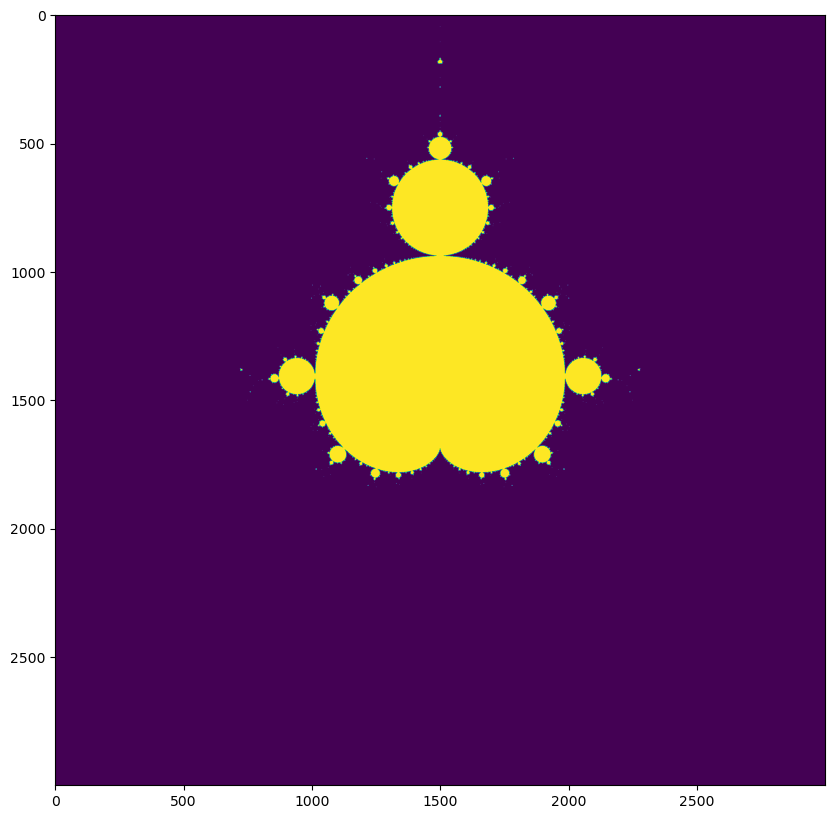

In [5]:
fix, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pixels.get());

In [ ]:
num_bins = 100

@nb.cuda.jit
def fill_random(rng_states, num_trials, histogram):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        histogram[thread_idx, int(xoroshiro128p_uniform_float32(rng_states, thread_idx) * num_bins)] += 1

def starting_seed():
    return np.frombuffer(os.urandom(8), dtype=np.int64)[0]

num_threads = 1024
num_blocks = 160
num_samples = 100000
rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())
histogram = cp.zeros((num_threads * num_blocks, num_bins), dtype=np.uint64)
fill_random[num_blocks, num_threads](rng_states, num_samples, histogram)

plt.plot(((histogram.sum(axis=0) - (num_threads * num_blocks * num_samples / num_bins)) / np.sqrt(num_threads * num_blocks * num_samples)).get());

In [6]:
@nb.cuda.jit
def count_random(rng_states, num_trials, num_in_set):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*4 - 2
        y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*4 - 2
        if not divergent(x, y):
            num_in_set[thread_idx] += 1

def starting_seed():
    return np.frombuffer(os.urandom(8), dtype=np.int64)[0]

def area_random(num_total_trials):
    num_threads = 1024
    num_blocks = 1024
    num_trials = num_total_trials // (num_threads * num_blocks)
    assert num_trials > 0
    assert num_trials * num_threads * num_blocks == num_total_trials

    rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())
    num_in_set = cp.zeros(num_threads * num_blocks, dtype=np.uint64)

    count_random[num_blocks, num_threads](rng_states, num_trials, num_in_set)

    return float(4**2 * num_in_set.sum() / num_total_trials)

In [7]:
@nb.cuda.jit
def count_pixels(num_in_set):
    i, j = nb.cuda.grid(2)
    if i < num_in_set.shape[0] and j < num_in_set.shape[1]:
        x = -2 + 4*(i + 0.5)/num_in_set.shape[0]
        y = -2 + 4*(j + 0.5)/num_in_set.shape[1]
        if not divergent(x, y):
            num_in_set[i, j] += 1

def close_to_square(num_total_trials):
    num_x = int(np.ceil(np.sqrt(num_total_trials)))
    num_y = int(num_total_trials / num_x)
    while num_x * num_y < num_total_trials:
        num_x -= 1
        num_y = int(num_total_trials / num_x)

    assert num_x * num_y == num_total_trials
    return num_x, num_y

def area_pixels(num_total_trials):
    num_x, num_y = close_to_square(num_total_trials)
    num_threads = (32, 32)
    num_blocks = (int(np.ceil(num_x / 32)), int(np.ceil(num_y / 32)))

    num_in_set = cp.zeros((num_x, num_y), dtype=np.uint64)

    count_pixels[num_blocks, num_threads](num_in_set)

    return float(4**2 * num_in_set.sum() / num_total_trials)

double precision

In [24]:
%timeit -r1 -n1 print(area_random(10*1024**2))

1.509185791015625
22.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


single precision

In [35]:
%timeit -r1 -n1 print(area_random(10*1024**2))

1.5057266235351563
696 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
float_trials = []
for _ in range(10):
    float_trials.append(area_random(10*1024**2))

In [24]:
np.std(float_trials)

0.0013001768380483155

In [8]:
trials = []
for _ in range(10):
    print("trial")
    trials.append(area_random(1000*10*1024**2))

trial
trial
trial
trial
trial
trial
trial
trial
trial
trial


In [15]:
f"{np.mean(trials):.5f} ± {np.std(trials):.5f}"

'1.50663 ± 0.00005'

In [16]:
f"{1.50659 - np.mean(trials):.5f}"

'-0.00004'

In [18]:
(1.50659 - np.array(trials)) / 0.00001

array([  4.26443481,  -4.62686157,  -0.64126587,  -7.34994507,
        -0.86190796,   1.01919556,  -6.45837402,  -1.73165894,
       -14.16055298,  -6.77575684])

In [20]:
10*1000*10*1024**2 / 88e12

0.0011915636363636363

In [ ]:
@nb.cuda.jit
def dots(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    if x**2 + y**2 < 1:
        outx[thread_idx] = x
        outy[thread_idx] = y

num_threads = 1024
num_blocks = 1024
starting_seed = np.frombuffer(os.urandom(8), dtype=np.int64)[0]
rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed)

outx = cp.zeros(num_threads * num_blocks, dtype=np.float32)
outy = cp.zeros(num_threads * num_blocks, dtype=np.float32)

dots[num_blocks, num_threads](rng_states, outx, outy)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(outx.get(), outy.get(), marker=".");

Some resources:

* [Usenet thread about computing Mandelbroit areas](https://ics.uci.edu/~eppstein/junkyard/mand-area.html), which started exactly 5 days after the first release of Python (February 25, 1991).
* [A Statistical Investigation of the Area of the Mandelbroit Set](https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf) by Kerry Mitchell (2001).
* [Area of th Mandelbroit Set](http://www.mrob.com/pub/muency/areaofthemandelbrotset.html) by Robert P. Munafo (2003). All of the techniques and gotchas are described there. Particularly interesting is the [area history](http://www.mrob.com/pub/muency/areahistory.html) (earliest known attempt to compute the area was a high school thesis in 1988, which got a value of 1.57. I think it's [this guy](https://www.linkedin.com/in/tord-malmgren-5848a0142/?originalSubdomain=se).) Also—very important—[this comment on Monte Carlo sampling](http://www.mrob.com/pub/muency/montecarlo.html).
* [Numerical estimation of the area of the Mandelbrot set](https://www.foerstemann.name/labor/area/Mset_area.pdf) by Thorsten Förstemann (2012).
* [On a numerical approximation of the boundary structure and of the area of the Mandelbrot set](https://link.springer.com/article/10.1007/s11071-015-1917-4) by Ioannis Andreadis and Theodoros E. Karakasidis (2015).
* [MathOverflow: is the area even computable?](https://mathoverflow.net/q/249617) (2016).
* [New Approximations for the Area of the Mandelbroit Set](https://arxiv.org/abs/1410.1212) by Daniel Bittner, Long Cheong, Dante Gates, Hieu D. Nguyen (2015). Referenced on [MathOverflow](https://mathoverflow.net/q/453862) (2023).

Is that the latest publication? [One paper](https://arxiv.org/abs/2305.17848) (2023) references it, and you'd think that any newer papers would do so. That new publication says,

> As for the area of the Mandelbrot set, the question of estimating the area has been stated by many, in particular hobby mathematicians.

Also, it says, "$M$ must be contained in $[-2, 1] × [-\frac{3}{2}, \frac{3}{2}]$, which has area $9$." That would be a better sample box than the area-16 box we're using above.